In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
import sys
sys.path.append('src/')
from models.vae import MusicVAE
from save_midi import save_notes_and_durations
from preprocess import parse_files_to_sequences, limit_uniq_notes, get_dictionaries

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = parse_files_to_sequences(folderpath, track_name)

In [4]:
notes, durations = limit_uniq_notes(notes, durations, 150)

In [5]:
note_dictionary, inv_note_dictionary, notes_to_int, \
duration_dictionary, inv_dur_dictionary, durations_to_int = get_dictionaries(notes, durations)

In [6]:
def prepare_sequences(notes, durations, length, step, n_notes, n_durations):
    batch_size = 32
    note_sequences = []
    dur_sequences = []
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        dur_sequences.append(durations[i: i + length])
    
    note_sequences = np.array(note_sequences)
    dur_sequences = np.array(dur_sequences)
    
    length = (len(note_sequences) // batch_size) * batch_size
    indicies = np.arange(length)
    np.random.shuffle(indicies)
    
    note_targets = to_categorical(note_sequences[indicies], n_notes)    
    dur_targets = to_categorical(dur_sequences[indicies], n_durations)
    sequences = [note_sequences[indicies], dur_sequences[indicies]]
    targets = [note_targets, dur_targets]
    return sequences, targets

In [7]:
X, y = prepare_sequences(notes_to_int, durations_to_int, 128, 1, len(note_dictionary), len(duration_dictionary))
X[0].shape

(18688, 128)

In [8]:
y[0].shape

(18688, 128, 150)

In [9]:
model = MusicVAE(
    kernel_size = 32,
    encoder_filters = [32, 32, 32, 32],
    encoder_strides = [1, 2, 2, 1],
    decoder_filters = [32, 32, 32, 32],
    decoder_strides = [1, 2, 2, 1],
    n_notes = len(note_dictionary),
    n_durations = len(duration_dictionary),
    emb_size = 16,
    input_dim = X[0].shape[1],
    latent_dim = 2,
    loss_factor = 500
)

In [10]:
model.compile(0.0005)

In [11]:
model.model.fit(
    X, y,
    shuffle=True,
    batch_size=32,
    epochs=10
)

Epoch 1/10
584/584 [==============================] - 53s 88ms/step - cce_notes: 2053.3086 - cce_durations: 688.0022 - kl: 6.6041 - loss: 2747.9146
Epoch 2/10
584/584 [==============================] - 48s 82ms/step - cce_notes: 1802.1425 - cce_durations: 609.2059 - kl: 7.3527 - loss: 2418.7009
Epoch 3/10
584/584 [==============================] - 48s 82ms/step - cce_notes: 1746.5997 - cce_durations: 606.4688 - kl: 7.6512 - loss: 2360.7197
Epoch 4/10
584/584 [==============================] - 43s 74ms/step - cce_notes: 1716.1580 - cce_durations: 602.6614 - kl: 7.8611 - loss: 2326.6807
Epoch 5/10
584/584 [==============================] - 43s 74ms/step - cce_notes: 1696.3146 - cce_durations: 599.5885 - kl: 8.0574 - loss: 2303.9609
Epoch 6/10
584/584 [==============================] - 49s 83ms/step - cce_notes: 1677.2709 - cce_durations: 597.2448 - kl: 8.2868 - loss: 2282.8022
Epoch 7/10
584/584 [==============================] - 57s 98ms/step - cce_notes: 1659.5983 - cce_durations: 593.

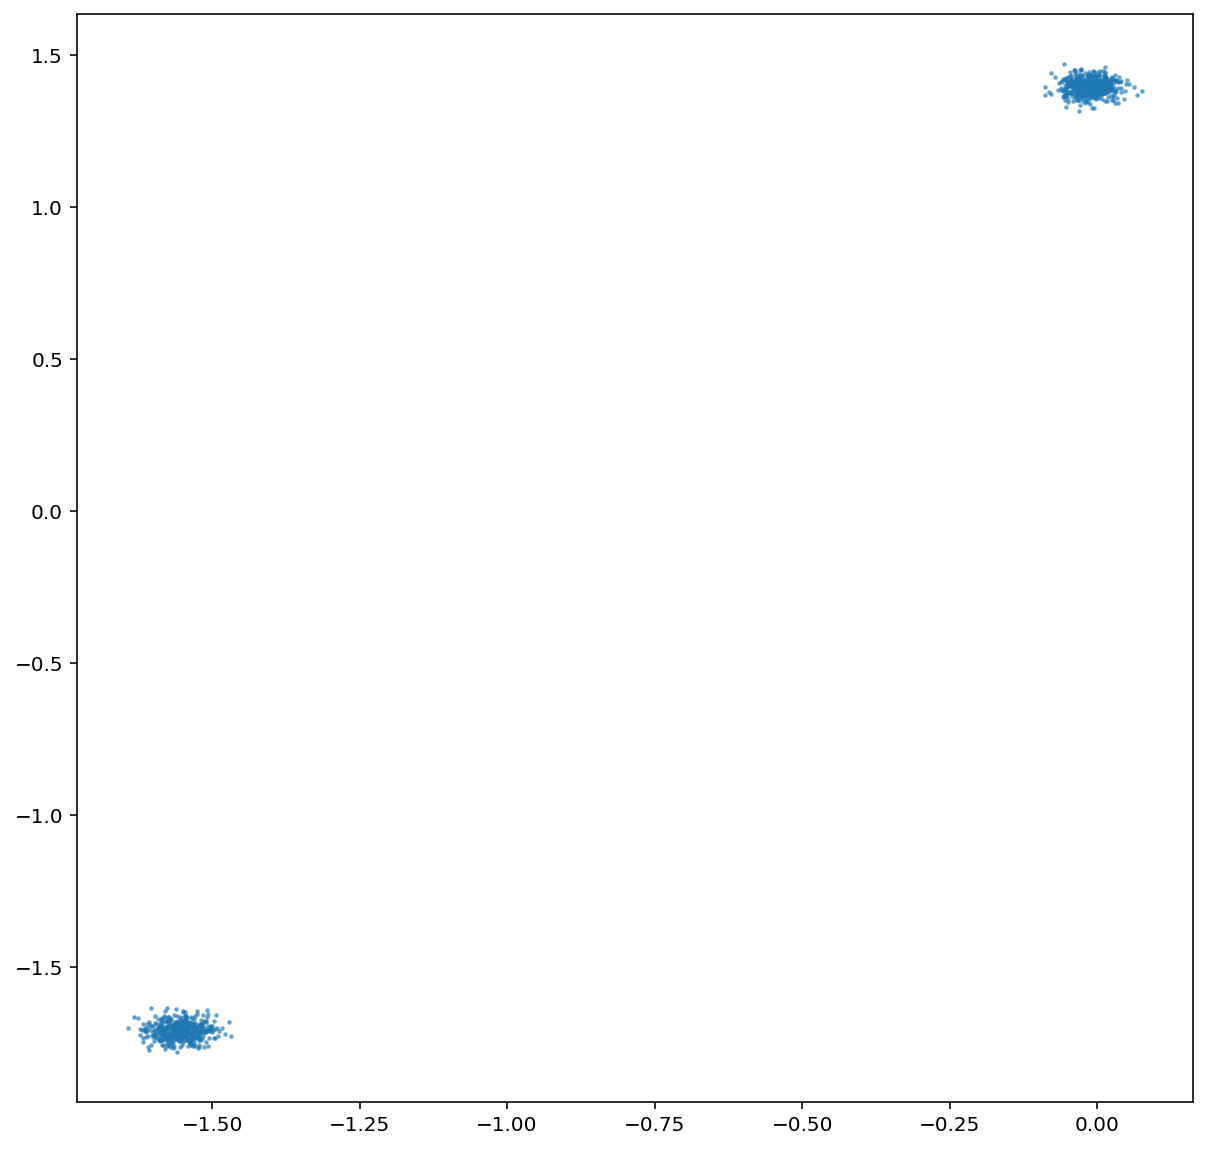

In [12]:
example_idx = np.random.choice(range(len(X)), 1000)
example_states = [X[0][example_idx], X[1][example_idx]]

_, _, z_points = model.encoder.predict(example_states)

plt.figure(figsize=(10, 10))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , alpha=0.5, s=2)
plt.show()

In [13]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [15]:
temperatures = [0.0, 0.5, 0.9]

for temperature in temperatures:
    generated_notes = []
    generated_durations = []
    predicted_notes, predicted_durations = model.decoder.predict(np.array([[-1.5, -1.6]]))
    for i in range(predicted_notes.shape[1]):
        generated_notes.append(sample(predicted_notes[0][i], temperature))
        generated_durations.append(sample(predicted_durations[0][i], temperature))
        
    generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]
    save_notes_and_durations(generated, f'output/vae/output_{temperature}_down')